In [1]:
pip install textblob
pip install transformers


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importamos las librerías necesarias
from __future__ import absolute_import, division, print_function

import re
import string 
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import hdbscan
from joblib import Memory
from unidecode import unidecode
from nltk.corpus import stopwords
from sklearn.datasets import make_blobs
import gensim.models.word2vec as w2v
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
from textblob import TextBlob
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
# Descargamos los recursos necesarios de NLTK, específicamente las stopwords en español. 
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sarya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Ruta del archivo CSV local
ruta_csv = "PARTIDAA.csv"

In [5]:
# Cargamos los datos, almacenandolo en un DataFrame de Pandas
data = pd.read_csv(ruta_csv, encoding="latin1")

In [6]:
# Verificamos si el archivo CSV existe
import os.path
if not os.path.exists(ruta_csv):
    raise FileNotFoundError(f"No se encontró el archivo CSV en la ruta especificada: {ruta_csv}")

In [7]:
# Palabras a eliminar redundantes
palabras_a_eliminar = ['mas', 'si', 'tan', 'habia', 'asi', 'oh', 'vez', 'y', 'h', 'mismo', 'aunque', 'mientras',
                       'que', 'aun', 'seras', 'cualquier', 'misma', 'mmpppfff', 'rurik', 'jum', 'wilfrick', 'jeet',
                       'julgram', 'thrommel', 'beran', 'dennek', 'caranthir', 'groak', 'jimblecap', 'gulgram', 'orsik',
                       'soren', 'ay', 'grit', 'tambien', 'groac']


In [8]:
    # Convertimos el contenido de la comuna texto en string
data["Texto"] = data["Texto"].astype(str)

    # Preprocesamiento de texto
data["texto_limpio"] = data["Texto"].str.lower()  # Convertimos a minúsculas
data["texto_limpio"] = data["texto_limpio"].apply(unidecode)  # Eliminamos acentos
data["texto_limpio"] = data["texto_limpio"].apply(lambda x: re.sub(r"\d+", " ", x))  # Eliminamos números
data["texto_limpio"] = data["texto_limpio"].str.translate(
    str.maketrans(string.punctuation, " " * len(string.punctuation))
)  # Eliminamos signos de puntuación
data["texto_limpio"] = data["texto_limpio"].str.replace(r"\s{2,}", " ", regex=True).str.strip()  # Eliminamos espacios innecesarios
    # Palabras a eliminar adicionales
stop = stopwords.words("spanish") + palabras_a_eliminar
data["texto_limpio"] = data["texto_limpio"].apply(
    lambda x: " ".join([word for word in x.split() if word not in (stop)])
)  # Eliminamos las stopwords


In [9]:
# Tokenización. Dividimos el texto limpio en tokens (palabras) para su posterior procesamiento.
tokensrol = [list(texto.split()) for texto in data['texto_limpio']]

In [10]:
print(tokensrol)

[['avatares', 'vida', 'llevaron', 'combatir', 'invasiones', 'humanoides', 'montanas', 'lortmils', 'teniais', 'propias', 'motivaciones', 'enrolaros', 'diferentes', 'batallones', 'incursiones', 'destinadas', 'expulsar', 'humanoides', 'territorios', 'pertenecientes', 'ancestrales', 'clanes', 'enanos', 'varias', 'misiones', 'organizadas', 'coincidisteis', 'campo', 'batalla', 'disteis', 'cuenta', 'habilidades', 'compenetraban', 'casi', 'perfeccion', 'formasteis', 'especie', 'escuadron', 'especializado', 'misiones', 'concretas', 'experiencia', 'campo', 'batalla', 'unisteis', 'proteger', 'diferentes', 'clanes', 'enanos', 'cierto', 'tiempo', 'gozasteis', 'cierta', 'fama', 'riqueza', 'hoy', 'parece', 'siniestro', 'ano', 'comun', 'ac', 'malvados', 'cultistas', 'construyeron', 'capilla', 'cerca', 'pueblo', 'nulb', 'lugar', 'profano', 'atrajo', 'adoradores', 'bandidos', 'orcos', 'gnolls', 'indeseables', 'finalmente', 'cultistas', 'expandieron', 'estructuras', 'construir', 'conocido', 'templo', 'ma

In [11]:
# Entrenamos un modelo Word2Vec sobre los tokens para crear representaciones vectoriales de las palabras
rol2vec = w2v.Word2Vec(
    tokensrol,
    vector_size=50,  # Reducimos el tamaño del vector
    window=3,  # Tamaño de la ventana de contexto
    min_count=1,  # Aceptamos palabras que aparecen al menos una vez
    workers=2,  # Usamos dos núcleos de CPU
)
rol2vec.save("rol_word2vec_model.model")  # Guardamos el modelo

In [12]:
# Ejemplo de palabras similares a "magia"
similar_words_magia = rol2vec.wv.most_similar("magia")
print("Palabras similares a 'magia':", similar_words_magia)

Palabras similares a 'magia': [('continuo', 0.5517002940177917), ('grabo', 0.46825912594795227), ('lado', 0.46211525797843933), ('disculpad', 0.42598873376846313), ('forma', 0.41744449734687805), ('cautivo', 0.4152204692363739), ('ocurriros', 0.41037052869796753), ('sintieron', 0.4026062786579132), ('jugar', 0.40196770429611206), ('guardias', 0.3986649513244629)]


In [13]:
# Ejemplo de palabras similares a "disciplina"
similar_words_disciplina = rol2vec.wv.most_similar("disciplina")
print("Palabras similares a 'disciplina':", similar_words_disciplina)

Palabras similares a 'disciplina': [('recuerdos', 0.5104620456695557), ('creo', 0.4909777045249939), ('horda', 0.4846702516078949), ('marcho', 0.451127290725708), ('asientos', 0.38866427540779114), ('embargo', 0.38759520649909973), ('rebosa', 0.3807078003883362), ('detente', 0.37873977422714233), ('pilares', 0.3767443001270294), ('sorprendente', 0.37432533502578735)]


In [14]:
# Ejemplo de palabras similares a "familia"
similar_words_familia = rol2vec.wv.most_similar("familia")
print("Palabras similares a 'familia':", similar_words_familia)

Palabras similares a 'familia': [('estancado', 0.4675644636154175), ('representar', 0.4466162919998169), ('devuelta', 0.42274948954582214), ('tendreis', 0.4085046350955963), ('gritos', 0.407482385635376), ('ja', 0.3988396227359772), ('ayudare', 0.392880380153656), ('lado', 0.3912065625190735), ('viveres', 0.38918256759643555), ('avance', 0.38628923892974854)]


In [15]:
# Configuramos y aplicamos HDBSCAN el algoritmo de clustering HDBSCAN a los datos
clusterer = hdbscan.HDBSCAN(
    algorithm='best',
    alpha=1.0,
    approx_min_span_tree=True,
    gen_min_span_tree=True,
    leaf_size=40,
    memory=Memory(location=None),
    metric='euclidean',
    min_cluster_size=5,
    min_samples=None,
    p=None
)

In [16]:
# Generamos datos ficticios para demostración
blobs, labels = make_blobs(n_samples=2000, centers=10, n_features=10)

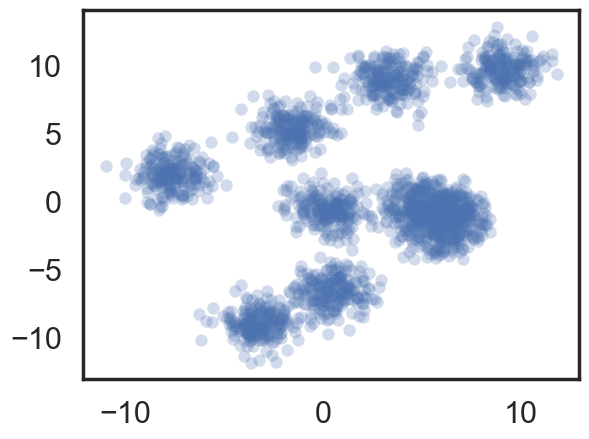

In [17]:
# Visualización de datos
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha': 0.25, 's': 80, 'linewidths': 0}
plt.scatter(blobs[:, 0], blobs[:, 1], c='b', **plot_kwds)

In [18]:
# Ajustamos el modelo HDBSCAN a los datos
clusterer.fit(blobs)

HDBSCAN(gen_min_span_tree=True)

<Axes: ylabel='$\\lambda$ value'>

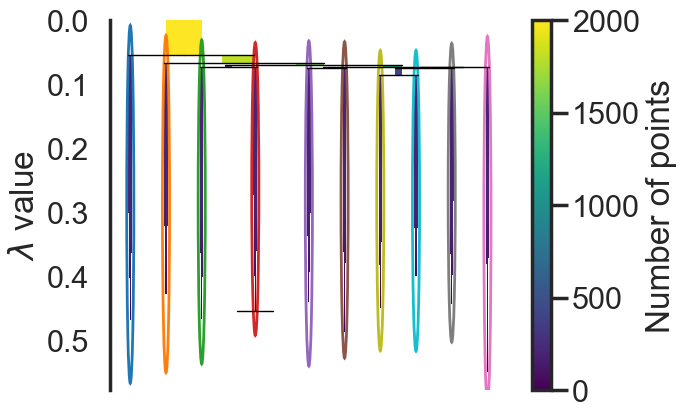

In [19]:
# Visualización de los resultados de la agrupación
pd.DataFrame(blobs).head()
clusterer.labels_
pd.crosstab(clusterer.labels_, columns='count')
clusterer.probabilities_

clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

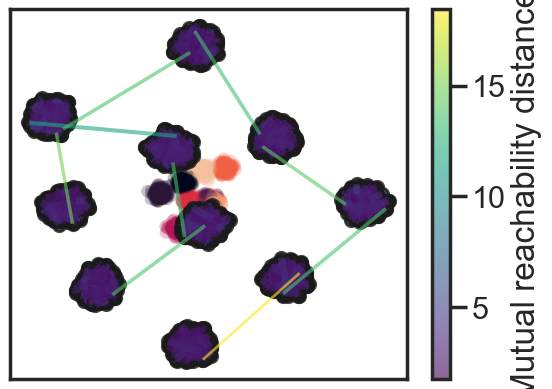

In [20]:

# Visualización de los clusters
plot_kwds = {'alpha': 0.25, 's': 80, 'linewidths': 0}
plt.scatter(blobs[:, 0], blobs[:, 1], c=clusterer.labels_, **plot_kwds)
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', edge_alpha=0.6, node_size=80, edge_linewidth=2)

plt.show()  # Mostramos los gráficos

In [21]:
def get_average_vector(words, model):
    # Filtrar las palabras que no están presentes en el modelo
    valid_words = [word for word in words if model.wv.has_index_for(word)]
    
    if valid_words:
        vectors = [model.wv[word] for word in valid_words]
        average_vector = np.mean(vectors, axis=0)
        return average_vector
    else:
        print("¡Atención! No hay palabras válidas en el texto.")
        return None

In [22]:
# Analizamos el sentimiento promedio de un conjunto de textos.
def sentiment_analysis(texts):
    sentiments = [TextBlob(text).sentiment.polarity for text in texts]
    average_sentiment = sum(sentiments) / len(sentiments)
    return average_sentiment

* C Cumplimiento Cómo respondemos a las normas y reglas establecidas, se tiene más énfasis en la calidad y precisión, competencia y experiencia.
* D Dominante Cómo respondemos a desafíos y retos, se tiene más énfasis en cumplir resultados, ven el panorama amplio.
* S Sereno/estable Cómo respondemos al ritmo de las cosas y a los cambios, se tiene más énfasis en cooperación, sinceridad y dependencia.
* I Influyente Cómo nos relacionamos e influimos en los demás, se tiene más énfasis en influenciar o persuadir a otros y en las relaciones.


In [24]:
# Realizamos un análisis de temas específicos (en este caso, basados en los factores DISC) en un conjunto de textos.
def topic_analysis(texts):
    # Palabras clave para identificar diferentes temas o roles basadas en los factores DISC
    disc_keywords = {
        'D': ['combate', 'liderazgo', 'desafío', 'estrategia', 'competencia'],
        'I': ['diálogo', 'colaboración', 'amistad', 'negociación', 'influencia'],
        'S': ['aventura', 'camaradería', 'tradición', 'familia', 'hogar'],
        'C': ['estrategia', 'misión', 'disciplina', 'objetivos', 'responsabilidad']
    }
    
    # Obtenemos todas las palabras clave asociadas a los factores DISC
    temas_comunes = [keyword for keywords in disc_keywords.values() for keyword in keywords]
    
    # Inicializamos el diccionario para almacenar los temas encontrados y sus frecuencias
    temas_encontrados = {}
    
    # Contamos la frecuencia de las palabras clave en los textos
    for tema in temas_comunes:
        temas_encontrados[tema] = sum(text.lower().count(tema) for text in texts)
    
    return temas_encontrados

In [25]:
def get_common_words(tokens):
    all_words = [word for sublist in tokens for word in sublist]
    word_freq = nltk.FreqDist(all_words)
    common_words = word_freq.most_common(10)
    return common_words

In [26]:
# Itera sobre los clusters encontrados, calcula el vector promedio de los tokens en el cluster, y realiza análisis de palabras comunes, sentimientos y temas específicos.
for cluster_id in np.unique(clusterer.labels_):
    cluster_indices = np.where(clusterer.labels_ == cluster_id)[0]
    print("Cluster ID:", cluster_id)
    print("Cluster Indices:", cluster_indices)
    
    invalid_indices = [idx for idx in cluster_indices if idx >= len(tokensrol)]
    print("Invalid Indices:", invalid_indices)
    
    # Filtra los tokens que están dentro del rango válido y calcula el vector promedio para el cluster.
    cluster_tokens = [tokensrol[idx] for idx in cluster_indices if idx < len(tokensrol)]
    cluster_vector = get_average_vector(cluster_tokens, rol2vec)
    
    if cluster_vector is not None:
        # Realiza un análisis de las palabras más comunes en el cluster.
        common_words = get_common_words(cluster_tokens)
        
        # Realiza un análisis de sentimientos para los tokens en el cluster.
        sentiment = sentiment_analysis([" ".join(tokens) for tokens in cluster_tokens])
        
        # Realiza un análisis de temas específicos en los tokens del cluster.
        temas = topic_analysis([" ".join(tokens) for tokens in cluster_tokens])
        
        print(f"Cluster {cluster_id} - Palabras más comunes: {common_words}")
        print(f"Cluster {cluster_id} - Sentimiento promedio: {sentiment}")
        print(f"Cluster {cluster_id} - Temas identificados: {temas}")
    else:
        print(f"No se pudo calcular el vector promedio para el Cluster {cluster_id}.")

Cluster ID: 0
Cluster Indices: [   4    5   23   27   43   52   55   56   75   80   91   92  104  106
  126  130  145  154  158  164  173  209  211  212  215  228  231  232
  234  238  258  307  310  344  356  359  379  393  398  403  414  418
  422  431  445  449  471  488  490  501  516  533  534  544  550  554
  559  570  598  613  629  636  655  680  682  699  701  731  733  742
  750  758  785  786  789  816  820  832  834  841  851  878  894  901
  922  933  936  953  955  957  960  962  969  996 1005 1006 1010 1014
 1022 1024 1036 1041 1060 1080 1109 1128 1139 1140 1164 1166 1184 1186
 1193 1200 1205 1224 1229 1234 1235 1244 1285 1312 1316 1319 1324 1338
 1354 1363 1387 1393 1403 1412 1422 1432 1443 1448 1457 1485 1486 1491
 1502 1504 1517 1519 1525 1559 1561 1562 1596 1597 1613 1618 1624 1626
 1638 1642 1660 1661 1662 1669 1676 1687 1688 1691 1697 1731 1736 1767
 1780 1794 1798 1810 1831 1838 1842 1845 1848 1854 1858 1864 1869 1876
 1882 1886 1891 1896 1904 1933 1934 1937 1938 

TypeError: unhashable type: 'list'

In [27]:
# Palabras más comunes por cluster
for cluster_id in np.unique(clusterer.labels_):
    cluster_indices = np.where(clusterer.labels_ == cluster_id)[0]
    cluster_tokens = [tokensrol[idx] for idx in cluster_indices if idx < len(tokensrol)]
    cluster_words = [word for tokens in cluster_tokens for word in tokens]
    word_freq = nltk.FreqDist(cluster_words)
    common_words = word_freq.most_common(10)
    print(f"Cluster {cluster_id} - Palabras más comunes: {common_words}")

Cluster 0 - Palabras más comunes: [('bosque', 14), ('bien', 9), ('negro', 8), ('camino', 7), ('lugar', 6), ('palabras', 6), ('aqui', 6), ('belgo', 6), ('arboles', 6), ('arbol', 6)]
Cluster 1 - Palabras más comunes: [('companeros', 6), ('hacia', 6), ('alli', 6), ('solo', 5), ('entonces', 5), ('bien', 5), ('lugar', 5), ('enano', 4), ('cierta', 4), ('puede', 4)]
Cluster 2 - Palabras más comunes: [('consejo', 12), ('tiempo', 8), ('bien', 8), ('hacer', 7), ('verdad', 7), ('principe', 7), ('despues', 6), ('supuesto', 6), ('momento', 6), ('mirada', 6)]
Cluster 3 - Palabras más comunes: [('bien', 11), ('consejo', 10), ('seria', 7), ('companeros', 7), ('solo', 7), ('principe', 7), ('habeis', 6), ('guerra', 6), ('gran', 6), ('hueste', 6)]
Cluster 4 - Palabras más comunes: [('rey', 7), ('solo', 6), ('sabueso', 6), ('aqui', 6), ('tal', 6), ('sol', 6), ('mapa', 5), ('tiempo', 5), ('lugar', 5), ('ahora', 5)]
Cluster 5 - Palabras más comunes: [('consejo', 6), ('encuentra', 6), ('bien', 6), ('principe

In [29]:
# Sentimiento promedio por cluster
for cluster_id in np.unique(clusterer.labels_):
    cluster_indices = np.where(clusterer.labels_ == cluster_id)[0]
    cluster_tokens = [tokensrol[idx] for idx in cluster_indices if idx < len(tokensrol)]
    sentiment = sentiment_analysis([" ".join(tokens) for tokens in cluster_tokens])
    print(f"Cluster {cluster_id} - Sentimiento promedio: {sentiment}")

Cluster 0 - Sentimiento promedio: -0.02380952380952381
Cluster 1 - Sentimiento promedio: -0.03793103448275863
Cluster 2 - Sentimiento promedio: 0.01818181818181818
Cluster 3 - Sentimiento promedio: -0.004651162790697674
Cluster 4 - Sentimiento promedio: -0.06060606060606061
Cluster 5 - Sentimiento promedio: -0.03911290322580645
Cluster 6 - Sentimiento promedio: -0.0013157894736842103
Cluster 7 - Sentimiento promedio: -0.007692307692307694
Cluster 8 - Sentimiento promedio: -0.0625
Cluster 9 - Sentimiento promedio: 0.006060606060606061


In [31]:
# Temas identificados por cluster
for cluster_id in np.unique(clusterer.labels_):
    cluster_indices = np.where(clusterer.labels_ == cluster_id)[0]
    cluster_tokens = [tokensrol[idx] for idx in cluster_indices if idx < len(tokensrol)]
    temas = topic_analysis([" ".join(tokens) for tokens in cluster_tokens])
    print(f"Cluster {cluster_id} - Temas identificados: {temas}")

Cluster 0 - Temas identificados: {'combate': 0, 'liderazgo': 0, 'desafío': 0, 'estrategia': 0, 'competencia': 0, 'diálogo': 0, 'colaboración': 0, 'amistad': 0, 'negociación': 0, 'influencia': 0, 'aventura': 0, 'camaradería': 0, 'tradición': 0, 'familia': 1, 'hogar': 0, 'misión': 0, 'disciplina': 1, 'objetivos': 0, 'responsabilidad': 0}
Cluster 1 - Temas identificados: {'combate': 1, 'liderazgo': 0, 'desafío': 0, 'estrategia': 0, 'competencia': 0, 'diálogo': 0, 'colaboración': 0, 'amistad': 0, 'negociación': 0, 'influencia': 0, 'aventura': 0, 'camaradería': 0, 'tradición': 0, 'familia': 0, 'hogar': 0, 'misión': 0, 'disciplina': 0, 'objetivos': 0, 'responsabilidad': 0}
Cluster 2 - Temas identificados: {'combate': 1, 'liderazgo': 0, 'desafío': 0, 'estrategia': 3, 'competencia': 0, 'diálogo': 0, 'colaboración': 0, 'amistad': 0, 'negociación': 0, 'influencia': 0, 'aventura': 2, 'camaradería': 0, 'tradición': 0, 'familia': 0, 'hogar': 1, 'misión': 0, 'disciplina': 2, 'objetivos': 0, 'respons

In [33]:
# Asigna etiquetas de cluster
unique_labels = np.unique(clusterer.labels_)
for i, label in enumerate(unique_labels):
    clusterer.labels_[clusterer.labels_ == label] = i

In [35]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [37]:
# Definiciones proporcionadas
pairs = [
     ("Me gusta liderar proyectos", "Dominante"),
    ("Disfruto trabajando en equipo", "Influyente"),
    ("Prefiero ambientes tranquilos y predecibles", "Estable"),
    ("Me gusta seguir reglas y procedimientos", "Concienzudo"),
    ("Prefiero ambientes tranquilos y predecibles.", "Estable"),
    ("Valoro la estabilidad", "Estable"),
    ("Soy muy competitivo", "Dominante"),
    ("Me gusta liderar proyectos", "Dominante"),
    ("Disfruto trabajando en equipo.", "Influyente"),
    ("Me encanta motivar a otros", "Influyente"),
    ("Presto atención a los detalles", "Concienzudo"),
    ("Me gusta seguir reglas y procedimientos", "Concienzudo"),
    ("Me gusta asumir responsabilidades grandes", "Dominante"),
    ("Tiendo a tomar decisiones rápidamente", "Dominante"),
    ("Me siento motivado por nuevas experiencias", "Influyente"),
    ("Me gusta estar rodeado de personas", "Influyente"),
    ("Disfruto de la tranquilidad y la paz", "Estable"),
    ("Prefiero mantener un ambiente predecible", "Estable"),
    ("Me gusta resolver conflictos de manera justa", "Dominante"),
    ("Me enfoco en hacer las cosas correctamente", "Dominante"),
    ("Siempre busco mejorar mis habilidades", "Dominante"),
    ("Valoro el cumplimiento de las normas", "Concienzudo"),
    ("Disfruto aprendiendo cosas nuevas", "Concienzudo"),
    ("Me gusta analizar problemas complejos", "Concienzudo"),
    ("Valoro la cooperación y el trabajo en equipo", "Influyente"),
    ("Prefiero un ambiente estable y seguro", "Estable"),
    ("Me gusta trabajar en proyectos desafiantes", "Dominante"),
    ("Me gusta influir en las decisiones del grupo", "Influyente"),
    ("Disfruto de la compañía de los demás", "Influyente"),
    ("Me gusta establecer y mantener rutinas", "Estable"),
    ("Prefiero seguir un plan establecido", "Estable"),
    ("Me gusta asumir roles de liderazgo", "Dominante"),
    ("Me gusta ser el centro de atención", "Influyente"),
    ("Me enfoco en los detalles y la precisión", "Concienzudo"),
    ("Me gusta seguir procedimientos establecidos", "Concienzudo"),
    ("Disfruto superando desafíos difíciles", "Dominante"),
    ("Me gusta liderar y motivar a otros", "Influyente"),
    ("Valoro la armonía en el entorno de trabajo", "Estable"),
    ("Prefiero ambientes organizados y estructurados", "Estable"),
    ("Me gusta dirigir y organizar actividades", "Dominante"),
    ("Me gusta ser reconocido por mis logros", "Influyente"),
    ("Me enfoco en la calidad y la excelencia", "Concienzudo"),
    ("Prefiero seguir instrucciones claras", "Concienzudo"),
    ("Me gusta tomar decisiones difíciles", "Dominante"),
    ("Me gusta liderar equipos hacia metas comunes", "Influyente"),
    ("Disfruto ayudando a otros a alcanzar su potencial", "Influyente"),
    ("Valoro la estabilidad y la consistencia", "Estable"),
    ("Prefiero evitar conflictos y confrontaciones", "Estable"),
    ("Me gusta dirigir y coordinar actividades", "Dominante"),
    ("Me gusta ser el centro de atención y la vida del grupo", "Influyente"),
    ("Me enfoco en los detalles y la precisión en mi trabajo", "Concienzudo"),
    ("Prefiero seguir un plan establecido en lugar de improvisar", "Concienzudo"),
]


In [39]:
# Definición de los estilos de comportamiento según el modelo DISC
def define_styles(definitions):
    disc_styles = {
        "Dominante": 0,
        "Influyente": 0,
        "Estable": 0,
        "Concienzudo": 0
    }
    
    for pair in definitions:
        text, style = pair
        disc_styles[style] += 1
    
    return disc_styles


In [41]:
# Mostrar el estilo de comportamiento predominante
disc_styles = define_styles(pairs)
predominant_style = max(disc_styles, key=disc_styles.get)
print("El estilo de comportamiento predominante es:", predominant_style)

El estilo de comportamiento predominante es: Dominante


In [47]:
def obtener_estilo_comportamiento(texto, pares):
    texto_preprocesado = texto.lower()  # Convertimos a minúsculas
    texto_preprocesado = unidecode(texto_preprocesado)  # Eliminamos acentos
    texto_preprocesado = re.sub(r"\d+", " ", texto_preprocesado)  # Eliminamos números
    texto_preprocesado = texto_preprocesado.translate(str.maketrans(string.punctuation, " " * len(string.punctuation)))  # Eliminamos signos de puntuación
    texto_preprocesado = re.sub(r"\s{2,}", " ", texto_preprocesado).strip()  # Eliminamos espacios innecesarios
    stop = stopwords.words("spanish")
    texto_preprocesado = " ".join([word for word in texto_preprocesado.split() if word not in stop])  # Eliminamos las stopwords
    
    similar_phrases = find_similar_phrases(model, texto_preprocesado, pares)  # Aquí deberías definir tu función find_similar_phrases que busca frases similares
    return similar_phrases

In [63]:
# Buscar frases similares para todas las definiciones
for pair in pairs:
    frase = pair[0]
    similares = find_similar_phrases(model, frase, pairs)
    print(f"Frases similares a '{frase}': {similares}")

Frases similares a 'Me gusta liderar proyectos': [('Me gusta trabajar en proyectos desafiantes', 0.34432798624038696), ('Me gusta liderar proyectos', 0.27556607127189636), ('Prefiero ambientes tranquilos y predecibles', 0.2705550491809845), ('Soy muy competitivo', 0.20677101612091064), ('Disfruto de la tranquilidad y la paz', 0.1910763829946518)]
Frases similares a 'Disfruto trabajando en equipo': [('Me gusta liderar equipos hacia metas comunes', 0.5975531935691833), ('Me gusta trabajar en proyectos desafiantes', 0.4102853834629059), ('Disfruto ayudando a otros a alcanzar su potencial', 0.2951049506664276), ('Me gusta dirigir y organizar actividades', 0.269568532705307), ('Prefiero seguir instrucciones claras', 0.22216208279132843)]
Frases similares a 'Prefiero ambientes tranquilos y predecibles': [('Prefiero un ambiente estable y seguro', 0.2899726629257202), ('Valoro la estabilidad', 0.2672066390514374), ('Me gusta liderar proyectos', 0.22162160277366638), ('Me gusta asumir roles de 

In [65]:
# Ejemplo de uso
frase_usuario = "Me gusta liderar proyectos"
estilo_predominante = obtener_estilo_comportamiento(frase_usuario, pairs)
print("Estilo de comportamiento asociado a la frase:", estilo_predominante)

Estilo de comportamiento asociado a la frase: [('Disfruto aprendiendo cosas nuevas', 0.36989426612854004), ('Prefiero seguir instrucciones claras', 0.30901405215263367), ('Me gusta seguir procedimientos establecidos', 0.2974255084991455), ('Disfruto trabajando en equipo', 0.2383773773908615), ('Me gusta liderar equipos hacia metas comunes', 0.1754731386899948)]


In [69]:
# Interacción en tiempo real con el usuario
while True:
    # Solicitar al usuario que ingrese una frase
    frase_usuario = input("Ingresa una frase para obtener el estilo de comportamiento asociado (o escribe 'salir' para terminar): ")

    # Salir del bucle si el usuario escribe "salir"
    if frase_usuario.lower() == "salir":
        print("¡Hasta luego!")
        break

    # Obtener el estilo de comportamiento asociado a la frase ingresada por el usuario
    estilo_predominante = obtener_estilo_comportamiento(frase_usuario, pairs)

    # Imprimir el estilo de comportamiento asociado a la frase
    print("Estilo de comportamiento asociado a la frase:", estilo_predominante)

Ingresa una frase para obtener el estilo de comportamiento asociado (o escribe 'salir' para terminar):  salir


¡Hasta luego!


In [71]:
# Preparamos los documentos para Doc2Vec
documents = [TaggedDocument(doc[0].split(), [i]) for i, doc in enumerate(pairs)]


In [73]:
# Entrenamos el modelo Doc2Vec
model = Doc2Vec(documents, vector_size=50, window=2, min_count=1, workers=4)
model.save("doc2vec_model.model")

In [75]:
# Ejemplo de búsqueda de la frase más similar
def find_similar_phrases(model, phrase, pairs):
    new_vector = model.infer_vector(phrase.split())
    similar_phrases = model.dv.most_similar([new_vector], topn=5)
    return [(pairs[sim[0]][0], sim[1]) for sim in similar_phrases]


In [77]:
# Buscar frases similares a "soy muy sociable"
similar_phrases = find_similar_phrases(model, "soy muy sociable", pairs)
print("Frases similares a 'soy muy sociable':", similar_phrases)

Frases similares a 'soy muy sociable': [('Prefiero seguir un plan establecido en lugar de improvisar', 0.24177922308444977), ('Prefiero ambientes tranquilos y predecibles.', 0.2220853865146637), ('Me gusta seguir procedimientos establecidos', 0.17401424050331116), ('Siempre busco mejorar mis habilidades', 0.1658141314983368), ('Me gusta tomar decisiones difíciles', 0.15908291935920715)]


In [79]:
# Buscar frases similares para todas las definiciones
for pair in pairs:
    frase = pair[0]
    similares = find_similar_phrases(model, frase, pairs)
    print(f"Frases similares a '{frase}': {similares}")

Frases similares a 'Me gusta liderar proyectos': [('Me gusta trabajar en proyectos desafiantes', 0.3454901874065399), ('Me gusta liderar proyectos', 0.27464625239372253), ('Prefiero ambientes tranquilos y predecibles', 0.2718350887298584), ('Soy muy competitivo', 0.20846375823020935), ('Me gusta seguir reglas y procedimientos', 0.19205783307552338)]
Frases similares a 'Disfruto trabajando en equipo': [('Me gusta liderar equipos hacia metas comunes', 0.5973443388938904), ('Me gusta trabajar en proyectos desafiantes', 0.40965819358825684), ('Disfruto ayudando a otros a alcanzar su potencial', 0.2975635230541229), ('Me gusta dirigir y organizar actividades', 0.2699049413204193), ('Prefiero seguir instrucciones claras', 0.22172701358795166)]
Frases similares a 'Prefiero ambientes tranquilos y predecibles': [('Prefiero un ambiente estable y seguro', 0.29446688294410706), ('Valoro la estabilidad', 0.26354992389678955), ('Me gusta liderar proyectos', 0.2229277640581131), ('Me gusta asumir rol

In [81]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [82]:
import torch
import torch.nn as nn
import torch.optim as optim

In [83]:
# Tokenización
def tokenize(sentence):
    return [token for token in sentence.split()]

In [84]:
# Preparar datos para entrenamiento
input_seqs = [tokenize(pair[0]) for pair in pairs]
target_seqs = [pair[1] for pair in pairs]

In [85]:
# Crear diccionarios de palabras
input_word2idx = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2}
output_word2idx = {}
for seq in input_seqs:
    for word in seq:
        if word not in input_word2idx:
            input_word2idx[word] = len(input_word2idx)

In [86]:
# Longitudes máximas de secuencia
max_input_len = max([len(seq) for seq in input_seqs])

In [87]:
# Convertir secuencias a tensores
def seq_to_tensor(seq, word2idx, max_len):
    tensor = torch.zeros(max_len, dtype=torch.long)
    for i, token in enumerate(seq):
        tensor[i] = word2idx[token]
    return tensor

In [88]:
input_tensors = [seq_to_tensor(seq, input_word2idx, max_input_len) for seq in input_seqs]

In [89]:
# Modelo simple para mapeo directo de entrada a salida
class SimpleSeq2Seq(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleSeq2Seq, self).__init__()
        self.embedding = nn.Embedding(input_size, output_size)

    def forward(self, input_tensor):
        return self.embedding(input_tensor)

In [99]:
# Entrenamiento del modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_vocab_size = len(input_word2idx)
output_vocab_size = 32  # Esto debería ser el tamaño de tu espacio de salida, dependiendo del número de clases
seq2seq_model = SimpleSeq2Seq(input_vocab_size, output_vocab_size).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignorar el índice del token de relleno
optimizer = optim.Adam(seq2seq_model.parameters())


In [101]:
# Entrenamiento
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    for input_tensor, target in zip(input_tensors, target_seqs):
        input_tensor = input_tensor.unsqueeze(0).to(device)
        target_tensor = torch.tensor([target], dtype=torch.long).to(device)
        optimizer.zero_grad()
        output = seq2seq_model(input_tensor)
        loss = criterion(output.view(-1, output_vocab_size), target_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(input_tensors)}")


ValueError: too many dimensions 'str'

In [103]:
# Función para predecir una clase
def predict_class(input_sentence):
    input_tensor = seq_to_tensor(tokenize(input_sentence), input_word2idx, max_input_len).unsqueeze(0).to(device)
    with torch.no_grad():
        output = seq2seq_model(input_tensor)
        _, predicted = torch.max(output, dim=2)
        return predicted.item()


In [105]:
# Ejemplo de uso
input_sentence = "Me gusta liderar proyectos"
predicted_class = predict_class(input_sentence)
print("Predicted class:", predicted_class)

RuntimeError: a Tensor with 12 elements cannot be converted to Scalar